In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
!unzip gdrive/MyDrive/Colab/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os as os
from PIL import Image
from tensorflow import keras
import tensorflow as tf

from keras.models import Sequential
#provides training and inference features on this model
from keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
#image data generator + load imager - er

import seaborn as sns

import cv2
import pandas as pd

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split



In [ ]:
print(os.listdir(r'chest_xray'))
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train=  get_training_data(r'chest_xray//train')
#train data set import

val =  get_training_data(r'chest_xray/val')
#same but val
#val lessens the chance of overfitting (the network gets to cozzy with the train data and is surprized by the test)

test =  get_training_data(r'chest_xray/test')
#same but test

['val', 'test', 'chest_xray', '__MACOSX', 'train']


<ipython-input-16-3d0e52cbbd97>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
l = []
for i in train:
  if(i[1] == 1):
    l.append("Pneumonia")
  else:
    l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

In [ ]:
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)

data_generator.fit(x_train)

In [ ]:
cnn = keras.Sequential([
  layers.Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', padding='same', input_shape=(150, 150, 1)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

  layers.Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
  layers.Dropout(0.3),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

  layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
  layers.Dropout(0.4),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

  layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'),
  layers.Dropout(0.5),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.6),
  layers.Dense(2, activation='sigmoid'),
])

cnn.summary()
cnn.compile(optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
def scheduler(epoch, learning_rate):
  if epoch < 2:
    return learning_rate
  else:
    return learning_rate * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
history = cnn.fit(
    data_generator.flow(x_train,y_train, batch_size = 32),
    epochs = 7, 
    validation_data = data_generator.flow(x_val, y_val),
    callbacks = [callback],
)

Epoch 1/7
163/163 [==============================] - 23s 63ms/step - loss: 0.5471 - accuracy: 0.8497 - val_loss: 95.0473 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/7
163/163 [==============================] - 10s 63ms/step - loss: 0.2449 - accuracy: 0.8735 - val_loss: 85.9655 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/7
163/163 [==============================] - 10s 63ms/step - loss: 0.1823 - accuracy: 0.8923 - val_loss: 69.1870 - val_accuracy: 0.5000 - lr: 9.0484e-04
Epoch 4/7
163/163 [==============================] - 10s 63ms/step - loss: 0.1452 - accuracy: 0.9369 - val_loss: 25.8521 - val_accuracy: 0.5000 - lr: 8.1873e-04
Epoch 5/7
163/163 [==============================] - 10s 62ms/step - loss: 0.1354 - accuracy: 0.9406 - val_loss: 49.6960 - val_accuracy: 0.5000 - lr: 7.4082e-04
Epoch 6/7
163/163 [==============================] - 10s 63ms/step - loss: 0.1217 - accuracy: 0.9459 - val_loss: 0.2608 - val_accuracy: 0.8750 - lr: 6.7032e-04
Epoch 7/7
163/163 [========================

In [ ]:
loss = cnn.evaluate(x_test,y_test)[0]
print('The loss of the cnn is ' + str(loss))
accuracy =  cnn.evaluate(x_test,y_test)[1]*100
print("The accuracy of the cnn is " + str(accuracy))

20/20 [==============================] - 0s 13ms/step - loss: 12.4973 - accuracy: 0.6250
The loss of the cnn is 12.49731159210205
20/20 [==============================] - 0s 12ms/step - loss: 12.4973 - accuracy: 0.6250
The accuracy of the cnn is 62.5


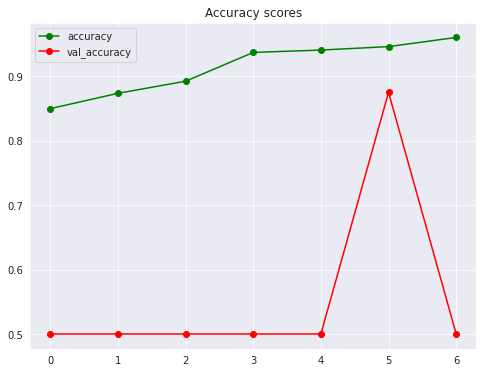

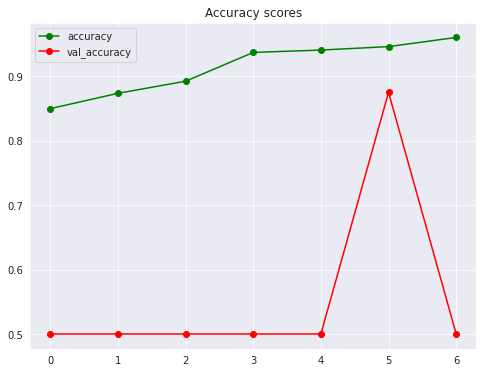

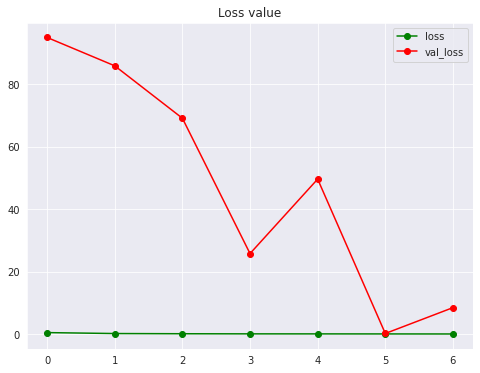

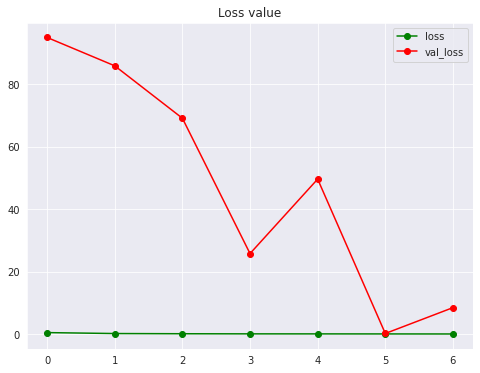

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'],'go-')
plt.plot(history.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'],'go-')
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()